# PACO
### Evert Nasedkin & Polychronis Patapis

This notebook provides an example for running the PACO algorithms developed by Flasseur et al. as a standalone python package. It requires that the notebook is run from the pipenv environment included with the git repository.

In [1]:
import paco.processing.paco as p
import paco.processing.fullpaco as f_paco
import paco.processing.fastpaco as fastPACO
from paco.util.util import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 
%matplotlib inline
#%matplotlib notebook


Here we generate a set of simulated ADI data. The signal is located at p0, and should have a SNR of 5, independant of the number of frames. The background is gaussian nosie with 1 sigma fluctations.

Note that it is recommended that nFrames be greater than the number of pixels in a patch (default is 49) to ensure that the covariance matrix can be properly inverted. 

/home/evert/.local/share/virtualenvs/PACO-4ds6DMDq/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/home/evert/.local/share/virtualenvs/PACO-4ds6DMDq/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


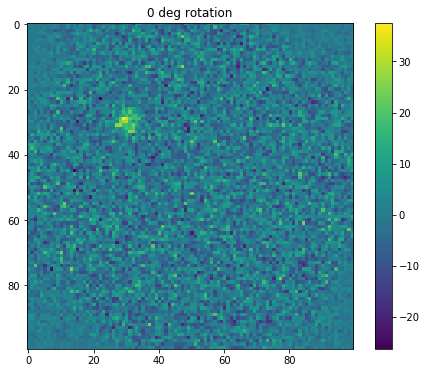

In [2]:
nFrames = 50
angles = np.linspace(0,60,nFrames)#np.array([0, 30, 45, 60, 90])
p0 = (30,30)
sigma = 1 # gaussian noise

mean = 0

images = [np.reshape(np.random.normal(mean, sigma, 10000), (100,100)) for j in range(nFrames)]
X,Y = np.meshgrid(np.arange(-50, 50),np.arange(-50, 50))
xx, yy = np.meshgrid(np.arange(-30, 70),np.arange(-30, 70))
s = gaussian2d(xx,yy,5.0/np.sqrt(nFrames), 2)

#images_signal = [i + s for i in images]
rot_noise = np.array([rotateImage(images[j], angles[j]) for j in range(nFrames)])
rot_sigs = np.array([rotateImage(s, angles[j]) for j in range(nFrames)])
rot_images = np.array([rot_noise[j] + rot_sigs[j] for j in range(nFrames)])

SNR = (s*nFrames)/(np.sqrt(nFrames) * sigma)
sum_ims = np.sum([rotateImage(rot_images[j], -1.0*angles[j]) for j in range(nFrames)], axis = 0)
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))
im = ax.imshow(sum_ims)
ax.set_title("0 deg rotation")
fig.colorbar(im,ax = ax)




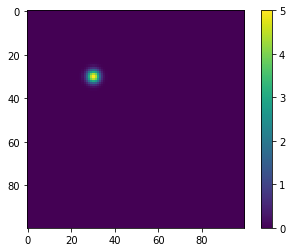

In [3]:
plt.figure()
plt.imshow(SNR)
plt.colorbar()

This cell runs the algorithm. The signal is normalised and used as the template signal for PACO. Both the SNR map and unbiased signal flux estimates can be run.

In [ ]:
xx, yy = np.meshgrid(np.arange(-4, 5),np.arange(-4, 5))
s = gaussian2d(xx,yy,1, 2)
s = s/np.sum(s)




In [ ]:
fp = fastPACO.FastPACO(image_stack = rot_images,
                       angles = angles,
                       psf = s,
                       psf_rad = 4,
                       px_scale = 1,
                       res_scale = 1)

#%prun fp.PACO(angles,scale = 1, model_name=psftemplate_model, params={"psf_template":s})
a,b = fp.PACO(cpu = 1)

Precomputing Statistics...


In [ ]:
img = b/np.sqrt(a)
#img = b/a
coords = fp.thresholdDetection(img,5.0)

plt.imshow(img)
plt.plot(coords[:,0],coords[:,1],'ro')
plt.colorbar()

In [ ]:
plt.figure()
snr = img.flatten()
plt.hist(snr[~np.isnan(snr)],bins = 20)
plt.yscale('log')
plt.show()

In [ ]:
print(coords)

est = fp.fluxEstimate(phi0s = coords,
                    eps = 0.05,
                    initial_est = 5)


print(est)
plt.imshow(est[0]*s)
plt.colorbar()
